In [1]:
import pandas as pd
import numpy as np

### Import data

In [2]:
#data = pd.concat([X, y_recovered, y_deaths, y_recovered_smoothed, y_deaths_smoothed], axis=1)

In [23]:
#Number of infected for past two weeks
X = pd.read_csv('data.csv').iloc[:,1:-3].values

#Number of deaths
y = pd.read_csv('data.csv').iloc[:,-2].values

In [24]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

## Quadratic Regularization

In [25]:
N = X.shape[1]

To do:
- Create matrix M
- Create matrix X (DONE)
- Compute X^TX
- Compute M^TM
- Verify M^TM value, if it coincides with the one G.O. wrote in report
- install library, define instances, run optimizer

In [26]:
pct_90 = int(np.ceil(90*len(X)/100))
pct_80 = int(np.ceil(80*len(X)/100))
pct_70 = int(np.ceil(70*len(X)/100))

X_train, X_test = X[:pct_80], X[pct_80:]
y_train, y_test =y[:pct_80], y[pct_80:]


In [27]:
import cvxopt

def create_M(N):
    M = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            if i==0:
                if j == 0:
                    M[i,j]=1
                else:
                    M[i,j]=0
            elif (i==j):
                M[i,j]=1
            elif (j == (i-1)):
                M[i,j] = -1
            else:
                M[i,j]=0
    return M

def generate_G(index):
    """index: represents k^*, gamma_{k^*} is such that gamma_0 <= gamma_1 <= ...<= gamma_{k^*} >= ... >= gamma_N
    This function generates a matrix G such that either gamma_index or gamma_{index+1} is the maximum
    """ 
    #this constraint verifies the gaussian-like distribution of the gamma
    G = np.zeros((N,N))
    for i in range(0, index):
        for j in range(N):
            if (i==j):
                G[i,j] = 1
            elif (j == i+1):
                G[i,j] = -1
                
    for i in range(index, N):
        for j in range(N):
            if (i==j):
                G[i,j] = -1
            elif (j == i+1):
                G[i,j] = 1
    
    # we do not put any condition on idx_th element, and use this line to verify that all gammas are superior or
    # equal to zero
    #G[index,:] = 0
    #G[index, 0] = -1

    
    #this constraint verifies that -gamma_i <= 0 <=> gamma_i >= 0 forall i
   # for i in range(N, 2*N):
    #    for j in range(N):
     #       if (i==N+j):
      #          G[i,j]=-1
    return G

def generate_params(X_train, y_train,k,lambda_=1.0):
    M = create_M(N)
    M_tilde = M.T @ M
    X_tilde = X_train.T @ X_train
    P = X_tilde + lambda_*(M_tilde)
    q = -X_train.T@y_train
    G = generate_G(k)
    h = np.zeros((N,1))
    for i in range(len(h)):
        h[i] = -0.0000001
    return P, q, G, h

def find_best_k(X_train, y_train, X_test, y_test, loss):
    """Returns index of maximum gamma that minimizes the mae loss"""
    loss = {}
    for k in range(N):
        P, q, G, h = generate_params(X_train, y_train, k)
        gammas = cvxopt_solve_qp(P,q, G, h)
        y_pred = X_test@gammas
        #if loss == 'mae':
         #   loss[k] = metrics.mean_absolute_error(y_test, y_pred)
        #elif loss == 'mape':
         #   print('here i am')
          #  print(mape(y_test,y_pred))
        loss[k] = mape(y_test,y_pred)
    return min(loss, key=loss.get)


def cvxopt_solve_qp(P, q, G=None, h=None, A=None, b=None):
    P = .5 * (P + P.T)  # make sure P is symmetric
    args = [cvxopt.matrix(P), cvxopt.matrix(q)]
    if G is not None:
        args.extend([cvxopt.matrix(G), cvxopt.matrix(h)])
        if A is not None:
            args.extend([cvxopt.matrix(A), cvxopt.matrix(b)])
    sol = cvxopt.solvers.qp(*args)
    if 'optimal' not in sol['status']:
        return None
    
    return np.array(sol['x']).reshape((P.shape[1],))

# ----------------------------#
#        LOSS FUNCTIONS 
# ----------------------------#

def mape(y_test, y_pred):
    return np.mean(np.abs((y_pred-y_test)/y_test))

def mspe(y_test, y_pred):
    return np.mean(np.square((y_pred-y_test)/y_test))


# ----------------------------#
#        GENERATE PREDICTIONS 
# ----------------------------#

index = find_best_k(X_train, y_train, X_test, y_test, 'mape')
P, q, G, h = generate_params(X_train, y_train, index)
gamma = cvxopt_solve_qp(P, q, G, h)
y_pred = X_test@gamma

     pcost       dcost       gap    pres   dres
 0: -3.4370e+04 -3.4370e+04  2e+01  4e+00  2e-08
 1: -3.4370e+04 -3.4370e+04  2e+00  4e-01  2e-09
 2: -3.4370e+04 -3.4367e+04  1e+00  3e-01  1e-09
 3: -3.4369e+04 -3.4364e+04  1e+00  2e-01  1e-09
 4: -3.4367e+04 -3.4355e+04  3e+00  2e-01  9e-10
 5: -3.4364e+04 -3.4352e+04  3e+00  2e-01  8e-10
 6: -3.4356e+04 -3.4348e+04  3e+00  8e-02  4e-10
 7: -3.4356e+04 -3.4344e+04  3e+00  8e-02  4e-10
 8: -3.4355e+04 -3.4335e+04  5e+00  7e-02  4e-10
 9: -3.4355e+04 -3.4334e+04  5e+00  7e-02  4e-10
10: -3.4345e+04 -3.4308e+04  1e+01  5e-02  3e-10
11: -3.4344e+04 -3.4303e+04  1e+01  5e-02  3e-10
12: -3.4337e+04 -3.4289e+04  2e+01  5e-02  2e-10
13: -3.4333e+04 -3.4278e+04  2e+01  4e-02  2e-10
14: -3.4290e+04 -3.4242e+04  3e+01  2e-02  1e-10
15: -3.4275e+04 -3.4237e+04  3e+01  2e-02  8e-11
16: -3.4247e+04 -3.4225e+04  2e+01  7e-03  3e-11
17: -3.4233e+04 -3.4222e+04  9e+00  2e-03  1e-11
18: -3.4227e+04 -3.4221e+04  4e+00  1e-03  6e-12
19: -3.4226e+04 -3.42

 5: -3.4355e+04 -3.4321e+04  1e+01  2e-01  2e-09
 6: -3.4345e+04 -3.4311e+04  1e+01  1e-01  2e-09
 7: -3.4334e+04 -3.4291e+04  2e+01  1e-01  1e-09
 8: -3.4329e+04 -3.4281e+04  2e+01  9e-02  1e-09
 9: -3.4315e+04 -3.4265e+04  2e+01  6e-02  7e-10
10: -3.4284e+04 -3.4218e+04  4e+01  4e-02  5e-10
11: -3.4243e+04 -3.4175e+04  5e+01  3e-02  3e-10
12: -3.4192e+04 -3.4148e+04  4e+01  1e-02  1e-10
13: -3.4191e+04 -3.4128e+04  3e+01  1e-02  1e-10
14: -3.4168e+04 -3.4090e+04  1e+01  6e-03  6e-11
15: -3.4150e+04 -3.4002e+04  2e+01  5e-03  6e-11
16: -3.4101e+04 -3.3890e+04  6e+01  4e-03  5e-11
17: -3.4101e+04 -3.3831e+04  7e+01  4e-03  5e-11
18: -3.4091e+04 -3.3805e+04  7e+01  4e-03  5e-11
19: -3.4071e+04 -3.3767e+04  9e+01  4e-03  4e-11
20: -3.3929e+04 -3.3539e+04  9e+01  2e-03  3e-11
21: -3.3919e+04 -3.3501e+04  1e+02  2e-03  3e-11
22: -3.3901e+04 -3.3457e+04  1e+02  2e-03  3e-11
23: -3.3862e+04 -3.3344e+04  1e+02  2e-03  2e-11
24: -3.3785e+04 -3.2930e+04  2e+02  2e-03  2e-11
25: -3.3132e+04 -3.1

In [28]:
gamma

array([3.91839154e-03, 1.39978346e-06, 1.29981075e-06, 1.19983878e-06,
       1.09986705e-06, 9.99895222e-07, 8.99923856e-07, 7.99952539e-07,
       6.99980928e-07, 6.00008524e-07, 5.00035366e-07, 4.00062809e-07,
       3.00090502e-07, 2.00119109e-07, 1.00144354e-07])

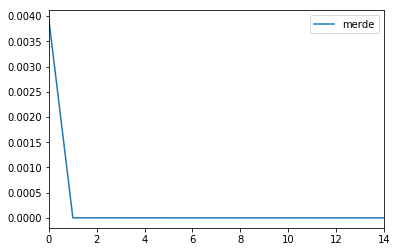

In [29]:
pd.DataFrame({'merde': gamma}).plot()

In [30]:
index

0

In [31]:
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df


,Actual,Predicted
0,23,26.786651
1,17,25.206579
2,14,24.100648
3,9,23.324078
4,8,22.206954
5,10,20.851017
6,11,19.969309
7,7,19.260275
8,6,17.728686
9,6,16.126530


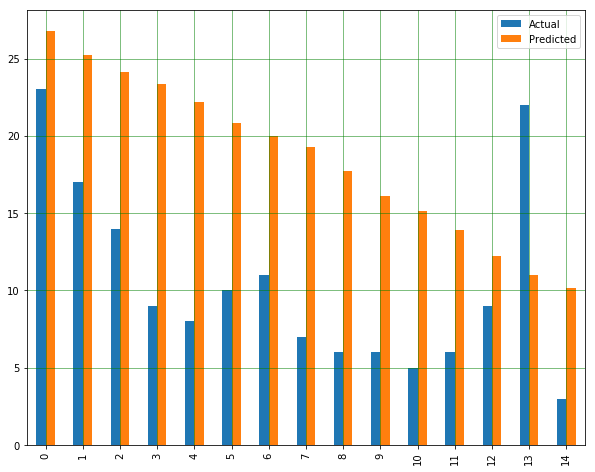

In [32]:
df.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [33]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Mean Absolute percentage error:', mape(y_test, y_pred))  
print('Mean Square percentage error:', mspe(y_test, y_pred))  






Mean Absolute Error: 9.600868076963076
Mean Squared Error: 101.83540171704135
Root Mean Squared Error: 10.09135281897533
Mean Absolute percentage error: 1.2416740842506233
Mean Square percentage error: 1.9988758287615889


### Run same but delete columns 6: and then delete columns 4: (see diff)

In [34]:
X_4 = X[:,:4]
X_6 = X[:,:6]
N = X_4.shape[1]
pct_95 = int(np.ceil(95*len(X_4)/100))
pct_90 = int(np.ceil(90*len(X_4)/100))
pct_85 = int(np.ceil(85*len(X_4)/100))
pct_80 = int(np.ceil(80*len(X_4)/100))
pct_70 = int(np.ceil(70*len(X_4)/100))

X_train, X_test = X_4[pct_80:pct_90], X_4[pct_90:]
y_train, y_test =y[pct_80:pct_90], y[pct_90:]

In [35]:
index = find_best_k(X_train, y_train, X_test, y_test, 'mape')
P, q, G, h = generate_params(X_train, y_train, index)
gamma = cvxopt_solve_qp(P, q, G, h)
y_pred = X_test@gamma



     pcost       dcost       gap    pres   dres
 0: -7.1344e+02 -7.1342e+02  4e+00  2e+00  8e-07
 1: -7.1344e+02 -7.1342e+02  2e-01  1e-01  4e-08
 2: -7.1342e+02 -7.1312e+02  1e-01  8e-02  3e-08
 3: -7.1260e+02 -7.1170e+02  4e-01  4e-02  1e-08
 4: -7.1259e+02 -7.0912e+02  1e+00  4e-02  1e-08
 5: -7.0990e+02 -7.0491e+02  2e+00  2e-02  8e-09
 6: -7.0991e+02 -6.9297e+02  4e+00  2e-02  8e-09
 7: -6.5672e+02 -6.5836e+02  2e+00  4e-05  2e-11
 8: -6.5815e+02 -6.5859e+02  5e-01  2e-06  9e-13
 9: -6.5834e+02 -6.5835e+02  5e-03  3e-08  1e-14
10: -6.5834e+02 -6.5834e+02  5e-05  3e-10  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -7.1344e+02 -7.1342e+02  4e+00  2e+00  2e-06
 1: -7.1344e+02 -7.1341e+02  2e-01  1e-01  9e-08
 2: -7.1342e+02 -7.1312e+02  1e-01  8e-02  6e-08
 3: -7.1137e+02 -7.1161e+02  9e-01  1e-02  1e-08
 4: -7.1162e+02 -7.1140e+02  1e+00  9e-03  7e-09
 5: -7.1128e+02 -7.1128e+02  1e-02  9e-05  7e-11
 6: -7.1127e+02 -7.1127e+02  1e-04  9e-07  7e-1

In [36]:
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})

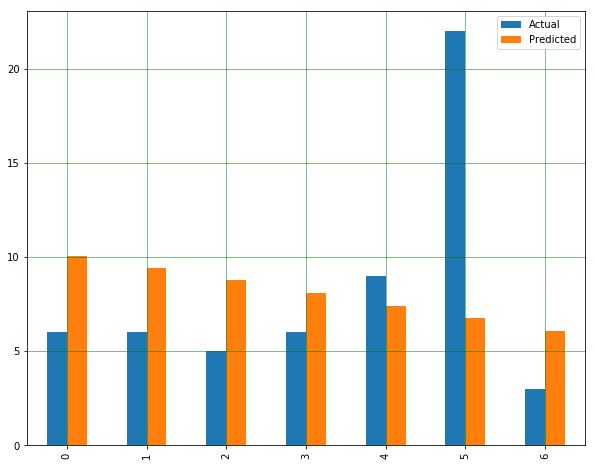

In [37]:
df.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [38]:
gamma


array([0.00050759, 0.00050748, 0.00050738, 0.00050728])

In [39]:
# X_4

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Mean Absolute percentage error:', mape(y_test, y_pred))  
print('Mean Square percentage error:', mspe(y_test, y_pred))  



Mean Absolute Error: 4.763325850797637
Mean Squared Error: 41.71452149768424
Root Mean Squared Error: 6.458677999225866
Mean Absolute percentage error: 0.6089611271909349
Mean Square percentage error: 0.4377335659023242


## Cross Validation

Here, we use the model with **4 gammas** to perform cross validation in order to find the best parameters. As we have around 70 data points, and need at least twice the number of gammas as number of training points, we start with 10 data points. We estimate 10 data points for training, and three for validation. As we have $\frac{69}{13}= 5.3$, we will do five folds. Each fold has 14 points, except for last fold with 13. We validate on two last data points. 

If we split every 13 data points, this is what we get:

In [40]:
splits_X = np.array_split(X_4, 4, axis=0)
splits_y = np.array_split(y, 4, axis=0)


In [41]:
def cross_val(splits_X, splits_y,lambda_=1.0):  
    y_vals = []
    y_preds = []
    mapes = []
    maes = []

    for X, y in zip(splits_X, splits_y):
        pct_90 = int(np.floor(90*len(X)/100))

        X_train = X[:pct_90]
        X_val = X[pct_90:]
        y_train = y[:pct_90]
        y_val = y[pct_90:]
        index = find_best_k(X_train, y_train, X_val, y_val, 'mape')
        P, q, G, h = generate_params(X_train, y_train, index,lambda_)
        gamma = cvxopt_solve_qp(P, q, G, h)
        y_pred = X_val@gamma

        y_vals.append(y_val)
        y_preds.append(y_pred)

        mapes.append(mape(y_val, y_pred))
        maes.append(metrics.mean_absolute_error(y_val, y_pred))
        
    y_vals = [item for sublist in y_vals for item in sublist]
    y_preds =[item for sublist in y_preds for item in sublist]
        
    return mapes, maes, y_vals, y_preds

mapes, maes, y_vals, y_preds = cross_val(splits_X, splits_y)

     pcost       dcost       gap    pres   dres
 0: -2.7639e+00 -2.7491e+00  5e+00  2e+00  1e-03
 1: -2.7322e+00 -2.7032e+00  5e-01  2e-01  1e-04
 2: -2.6637e+00 -2.6041e+00  1e-01  6e-02  3e-05
 3: -2.5833e+00 -2.5324e+00  4e-02  2e-02  8e-06
 4: -2.5830e+00 -2.3337e+00  7e-02  2e-02  8e-06
 5: -2.1285e+00 -1.4901e+00  3e-01  1e-02  4e-06
 6: -1.2458e+00 -1.2784e+00  3e-02  2e-18  8e-15
 7: -1.2772e+00 -1.2776e+00  5e-04  4e-19  9e-15
 8: -1.2776e+00 -1.2776e+00  5e-06  5e-22  1e-16
 9: -1.2776e+00 -1.2776e+00  5e-08  9e-19  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.7639e+00 -2.6350e+00  5e+00  2e+00  2e-03
 1: -2.7383e+00 -2.5641e+00  6e-01  3e-01  3e-04
 2: -2.6370e+00 -2.4373e+00  1e-01  1e-01  1e-04
 3: -2.3911e+00 -2.2394e+00  9e-02  4e-02  4e-05
 4: -2.3072e+00 -1.7016e+00  3e-01  3e-02  3e-05
 5: -1.2953e+00 -1.1743e+00  9e-02  3e-03  3e-06
 6: -1.1718e+00 -1.1709e+00  1e-03  3e-05  3e-08
 7: -1.1706e+00 -1.1706e+00  1e-05  3e-07  3e-1

In [42]:
np.mean(mapes)

0.47656330043585376

In [43]:
df = pd.DataFrame({'Actual': y_vals, 'Predicted': y_preds})
df


,Actual,Predicted
0,3,1.337363
1,4,1.674830
2,59,67.843799
3,54,72.344250
4,35,34.533266
5,28,33.288750
6,22,7.750256
7,3,7.012390


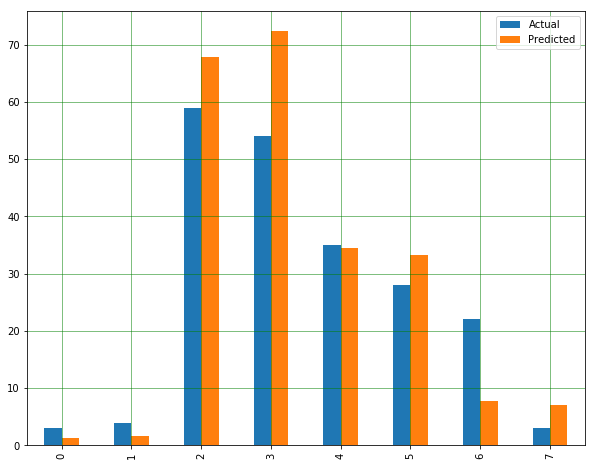

In [44]:
df.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

## Advancing Cross Val

In [50]:
# We want our train set to be of size 40, and then we shift of 10 data points at each new iteration.
# the size of our test set is the rest of the dataset points
splits = int(np.floor((X_4.shape[0] - 40)/10))

##

mapes = []
maes = []
y_vals = []
y_preds = []

for i in range(splits):

    begin = 10*i
    end = 40 + 10*i
    
    X_tr = X_4[begin:end,:]
    y_tr = y[begin:end]
    
    X_te = X_4[end:,:]
    y_te = y[end:]
    
    # Run the model
    
    index = find_best_k(X_tr, y_tr, X_te, y_te, 'mape')
    P, q, G, h = generate_params(X_tr, y_tr, index,10e-5)
    gamma = cvxopt_solve_qp(P, q, G, h)
    y_pred = X_te@gamma

    y_vals.append(y_te)
    y_preds.append(y_pred)

    mapes.append(mape(y_te, y_pred))
    maes.append(metrics.mean_absolute_error(y_te, y_pred))
        
y_vals = [item for sublist in y_vals for item in sublist]
y_preds =[item for sublist in y_preds for item in sublist]
        

     pcost       dcost       gap    pres   dres
 0: -1.5710e+04 -1.5710e+04  5e+00  2e+00  1e-07
 1: -1.5710e+04 -1.5710e+04  5e-01  2e-01  1e-08
 2: -1.5710e+04 -1.5709e+04  4e-01  2e-01  1e-08
 3: -1.5212e+04 -1.5733e+04  9e+02  2e-01  8e-09
 4: -1.5578e+04 -1.5774e+04  2e+03  1e-01  7e-09
 5: -1.5550e+04 -1.5680e+04  4e+02  3e-02  1e-09
 6: -1.5541e+04 -1.5550e+04  9e+02  3e-02  1e-09
 7: -1.5576e+04 -1.5448e+04  1e+02  5e-03  2e-10
 8: -1.5425e+04 -1.5241e+04  5e+01  2e-03  8e-11
 9: -1.5179e+04 -1.5189e+04  1e+01  2e-19  7e-17
10: -1.5189e+04 -1.5189e+04  1e-01  3e-21  1e-16
11: -1.5189e+04 -1.5189e+04  1e-03  1e-23  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.5710e+04 -1.5710e+04  5e+00  2e+00  2e-07
 1: -1.5710e+04 -1.5710e+04  3e-01  2e-01  2e-08
 2: -1.5710e+04 -1.5708e+04  3e-01  2e-01  2e-08
 3: -1.5696e+04 -1.5644e+04  3e+01  2e-01  2e-08
 4: -1.5635e+04 -1.5601e+04  2e+01  6e-02  6e-09
 5: -1.5590e+04 -1.5552e+04  4e+01  4e-02  5e-0

In [48]:
print('for each split we have the following MAPE losses: {}, \nResulting in a mean MAPE of {}'.format(mapes, np.mean(mapes)))


for each split we have the following MAPE losses: [1.0283912011742888, 0.9161159421719534, 1.0945887177310145], 
Resulting in a mean MAPE of 1.0130319536924188


### Find best hyperparameter $\lambda$

In [45]:
# this is the function we want to minimize
# we want to minimize the mean loss function MAE from our cross validation run
def f(lambda_):
    mapes, maes, y_vals, y_preds = cross_val(splits_X, splits_y, lambda_)
    return np.mean(maes)
    
    
    

In [26]:
from scipy.optimize import minimize

minimize(f,1.0,method='SLSQP')

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

 8: -9.6748e+05 -9.6748e+05  4e+00  2e-20  1e-16
 9: -9.6748e+05 -9.6748e+05  4e-02  2e-19  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0003e+06 -1.0003e+06  5e+00  2e+00  2e-09
 1: -1.0003e+06 -1.0003e+06  3e-01  1e-01  1e-10
 2: -1.0003e+06 -1.0003e+06  3e-01  1e-01  1e-10
 3: -9.9986e+05 -9.9733e+05  8e+02  1e-01  1e-10
 4: -9.9584e+05 -9.9498e+05  1e+04  1e-01  1e-10
 5: -9.9859e+05 -9.8834e+05  2e+04  1e-01  1e-10
 6: -9.8919e+05 -9.7442e+05  3e+03  3e-02  3e-11
 7: -9.6351e+05 -9.6664e+05  3e+03  5e-18  9e-16
 8: -9.6652e+05 -9.6655e+05  3e+01  5e-19  2e-16
 9: -9.6655e+05 -9.6655e+05  3e-01  2e-19  8e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0003e+06 -1.0003e+06  5e+00  2e+00  2e-09
 1: -1.0003e+06 -1.0003e+06  3e-01  2e-01  2e-10
 2: -1.0003e+06 -1.0003e+06  3e-01  2e-01  2e-10
 3: -9.9962e+05 -9.9880e+05  1e+03  2e-01  2e-10
 4: -9.9856e+05 -9.9568e+05  5e+03  2e-01  1e-10
 5: -9.9656e+05 -9.9365

     fun: 229.3819021317152
     jac: array([0.00011063])
 message: 'Optimization terminated successfully.'
    nfev: 3
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([1.])

In [27]:
from skopt import gp_minimize
from skopt.space import Real, Integer

space  = [Real(10**-5, 10**0, name='learning_rate')]

res = gp_minimize(f,space)
lambda_ = res['x'][0]

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-17
 7: -1.0566e+05 -1.0567e+05  5e+00  3e-17  1e-16
 8: -1.0566e+05 -1.0566e+05  6e-02  8e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  6e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  7e-01  4e-01  8e-08
 3: -1.0499e+05 -1.0585e+05  1e+03  1e-01  3e-08
 4: -1.0541e+05 -1.0607e+05  2e+03  9e-02  2e-08
 5: -1.0555e+05 -1.0592e+05  5e+02  2e-02  4e-09
 6: -1.0553e+05 -1.0573

 5: -9.9443e+05 -9.8380e+05  3e+03  3e-02  3e-11
 6: -9.6165e+05 -9.6804e+05  8e+03  9e-04  8e-13
 7: -9.6728e+05 -9.6752e+05  2e+02  5e-18  5e-16
 8: -9.6748e+05 -9.6748e+05  4e+00  2e-20  1e-16
 9: -9.6748e+05 -9.6748e+05  4e-02  2e-19  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0003e+06 -1.0003e+06  5e+00  2e+00  2e-09
 1: -1.0003e+06 -1.0003e+06  3e-01  1e-01  1e-10
 2: -1.0003e+06 -1.0003e+06  3e-01  1e-01  1e-10
 3: -9.9986e+05 -9.9733e+05  8e+02  1e-01  1e-10
 4: -9.9584e+05 -9.9498e+05  1e+04  1e-01  1e-10
 5: -9.9859e+05 -9.8834e+05  2e+04  1e-01  1e-10
 6: -9.8919e+05 -9.7442e+05  3e+03  3e-02  3e-11
 7: -9.6351e+05 -9.6664e+05  3e+03  5e-18  9e-16
 8: -9.6652e+05 -9.6655e+05  3e+01  5e-19  2e-16
 9: -9.6655e+05 -9.6655e+05  3e-01  2e-19  8e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0003e+06 -1.0003e+06  5e+00  2e+00  2e-09
 1: -1.0003e+06 -1.0003e+06  3e-01  2e-01  2e-10
 2: -1.0003e+06 -1.0003

 3: -2.7090e+06 -2.7071e+06  4e+02  6e-02  2e-11
 4: -2.7046e+06 -2.7070e+06  9e+03  6e-02  2e-11
 5: -2.7071e+06 -2.7122e+06  1e+04  6e-02  2e-11
 6: -2.7050e+06 -2.7063e+06  8e+03  3e-02  1e-11
 7: -2.7036e+06 -2.6932e+06  9e+03  3e-02  1e-11
 8: -2.6988e+06 -2.6809e+06  9e+03  2e-02  7e-12
 9: -2.6747e+06 -2.6347e+06  3e+03  8e-03  3e-12
10: -2.6154e+06 -2.6182e+06  3e+03  3e-18  8e-16
11: -2.6179e+06 -2.6181e+06  2e+02  7e-20  1e-16
12: -2.6180e+06 -2.6180e+06  2e+00  9e-19  8e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0003e+06 -1.0003e+06  5e+00  2e+00  9e-10
 1: -1.0003e+06 -1.0003e+06  3e-01  2e-01  7e-11
 2: -1.0003e+06 -1.0003e+06  3e-01  1e-01  6e-11
 3: -9.9572e+05 -9.9997e+05  9e+03  1e-01  6e-11
 4: -9.9324e+05 -1.0032e+06  2e+04  1e-01  6e-11
 5: -9.9934e+05 -1.0072e+06  4e+04  1e-01  5e-11
 6: -9.9210e+05 -9.8390e+05  5e+04  1e-01  5e-11
 7: -9.8976e+05 -9.8074e+05  9e+02  1e-02  6e-12
 8: -9.7859e+05 -9.6936e+05  8e+03  9e-03  4e-

 6: -2.7066e+06 -2.6842e+06  8e+03  4e-02  3e-11
 7: -2.6763e+06 -2.6301e+06  4e+03  1e-02  1e-11
 8: -2.6092e+06 -2.6123e+06  3e+03  2e-18  4e-16
 9: -2.6122e+06 -2.6123e+06  5e+01  4e-19  1e-16
10: -2.6123e+06 -2.6123e+06  5e-01  9e-19  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.7093e+06 -2.7093e+06  4e+00  2e+00  2e-09
 1: -2.7093e+06 -2.7093e+06  2e-01  1e-01  8e-11
 2: -2.7093e+06 -2.7093e+06  2e-01  9e-02  7e-11
 3: -2.7083e+06 -2.7088e+06  2e+03  9e-02  6e-11
 4: -2.7054e+06 -2.6980e+06  1e+04  8e-02  6e-11
 5: -2.7045e+06 -2.6956e+06  9e+03  7e-02  5e-11
 6: -2.7038e+06 -2.6672e+06  2e+04  5e-02  4e-11
 7: -2.6580e+06 -2.6145e+06  3e+03  2e-02  1e-11
 8: -2.6042e+06 -2.6049e+06  7e+02  2e-18  3e-16
 9: -2.6049e+06 -2.6049e+06  7e+00  9e-19  1e-16
10: -2.6049e+06 -2.6049e+06  7e-02  6e-19  9e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.7093e+06 -2.7093e+06  4e+00  2e+00  2e-09
 1: -2.7093e+06 -2.7093

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

 4: -1.0501e+05 -1.0619e+05  2e+03  2e-01  5e-08
 5: -1.0491e+05 -1.0735e+05  6e+03  1e-01  3e-08
 6: -1.0540e+05 -1.0620e+05  8e+02  4e-17  2e-16
 7: -1.0566e+05 -1.0577e+05  1e+02  2e-17  8e-17
 8: -1.0568e+05 -1.0569e+05  9e+00  2e-17  5e-17
 9: -1.0569e+05 -1.0569e+05  1e-01  2e-18  2e-17
10: -1.0569e+05 -1.0569e+05  1e-03  7e-18  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  6e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  1e-17  1e-16
 7: -1.0566e+05 -1.0567e+05  5e+00  1e-17  8e-17
 8: -1.0566e+05 -1.0566e+05  6e-02  2e-17  6e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.6689e+06 -3.6689e+06  5e+00  2e+00  2e-09
 1: -3.6689e+06 -3.6689

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  1e-17  1e-16
 6: -1.0566e+05 -1.0570e+05  4e+01  8e-18  1e-16
 7: -1.0566e+05 -1.0567e+05  5e+00  2e-17  1e-16
 8: -1.0566e+05 -1.0566e+05  6e-02  2e-17  2e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.6689e+06 -3.6689e+06  5e+00  2e+00  2e-09
 1: -3.6689e+06 -3.6689e+06  4e-01  2e-01  2e-10
 2: -3.6689e+06 -3.6689e+06  3e-01  1e-01  1e-10
 3: -3.6515e+06 -3.6643e+06  3e+04  1e-01  1e-10
 4: -3.6563e+06 -3.6164e+06  8e+04  1e-01  1e-10
 5: -3.6456e+06 -3.5998e+06  5e+04  7e-02  6e-11
 6: -3.6400e+06 -3.5268e+06  1e+05  5e-02  5e-11
 7: -3.5221e+06 -3.4152e+06  1e+04  1e-02  1e-11
 8: -3.3915e+06 -3.3936e+06  2e+03  2e-17  2e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-17
 7: -1.0566e+05 -1.0567e+05  5e+00  3e-17  1e-16
 8: -1.0566e+05 -1.0566e+05  6e-02  8e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  6e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  7e-01  4e-01  8e-08
 3: -1.0499e+05 -1.0585e+05  1e+03  1e-01  3e-08
 4: -1.0541e+05 -1.0607e+05  2e+03  9e-02  2e-08
 5: -1.0555e+05 -1.0592e+05  5e+02  2e-02  4e-09
 6: -1.0553e+05 -1.0573e+05  2e+02  5e-03  1e-09
 7: -1.0562e+05 -1.0565e+05  3e+01  2e-04  5e-11
 8: -1.0563e+05 -1.0564e+05  7e+00  6e-05  1e-11
 9: -1.0564e+05 -1.0564e+05  9e+00  3e-05  6e-12
10: -1.0564e+05 -1.0564e+05  9e-01  3e-18  1e-16
11: -1.0564e+05 -1.0564e+05  2e-02  5e-18  7e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  6e-07
 1: -1.0598e+05 -1.0598e+05  7e-01  3e-01  8e-08
 2: -1.0598e+05 -1.0597

 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-17
 7: -1.0566e+05 -1.0567e+05  5e+00  3e-17  1e-16
 8: -1.0566e+05 -1.0566e+05  6e-02  8e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  6e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  7e-01  4e-01  8e-08
 3: -1.0499e+05 -1.0585e+05  1e+03  1e-01  3e-08
 4: -1.0541e+05 -1.0607e+05  2e+03  9e-02  2e-08
 5: -1.0555e+05 -1.0592e+05  5e+02  2e-02  4e-09
 6: -1.0553e+05 -1.0573e+05  2e+02  5e-03  1e-09
 7: -1.0562e+05 -1.0565e+05  3e+01  2e-04  5e-11
 8: -1.0563e+05 -1.0564e+05  7e+00  6e-05  1e-11
 9: -1.0564e+05 -1.0564e+05  9e+00  3e-05  6e-12
10: -1.0564e+05 -1.0564e+05  9e-01  3e-18  1e-16
11: -1.0564e+05 -1.0564e+05  2e-02  5e-18  7e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

 4: -9.9324e+05 -1.0032e+06  2e+04  1e-01  6e-11
 5: -9.9934e+05 -1.0072e+06  4e+04  1e-01  5e-11
 6: -9.9210e+05 -9.8390e+05  5e+04  1e-01  5e-11
 7: -9.8976e+05 -9.8074e+05  9e+02  1e-02  6e-12
 8: -9.7859e+05 -9.6936e+05  8e+03  9e-03  4e-12
 9: -9.8315e+05 -9.7279e+05  1e+04  8e-03  3e-12
10: -9.6780e+05 -9.6879e+05  1e+03  8e-18  1e-15
11: -9.6815e+05 -9.6820e+05  5e+01  9e-19  2e-16
12: -9.6819e+05 -9.6819e+05  5e-01  1e-18  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1